In [ ]:
# Element
import os
import io
import time
import requests
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt

# clone the git repository and set it as the working directory
! git clone https://github.com/martin-marek/parking-space-occupancy
os.chdir('parking-space-occupancy')

# download the dataset
if not os.path.exists('dataset/data'):
    r = requests.get("https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2Frois_gopro.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('dataset/data')

Cloning into 'parking-space-occupancy'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 86 (delta 37), reused 61 (delta 19), pack-reused 0
Receiving objects: 100% (86/86), 3.57 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (37/37), done.


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


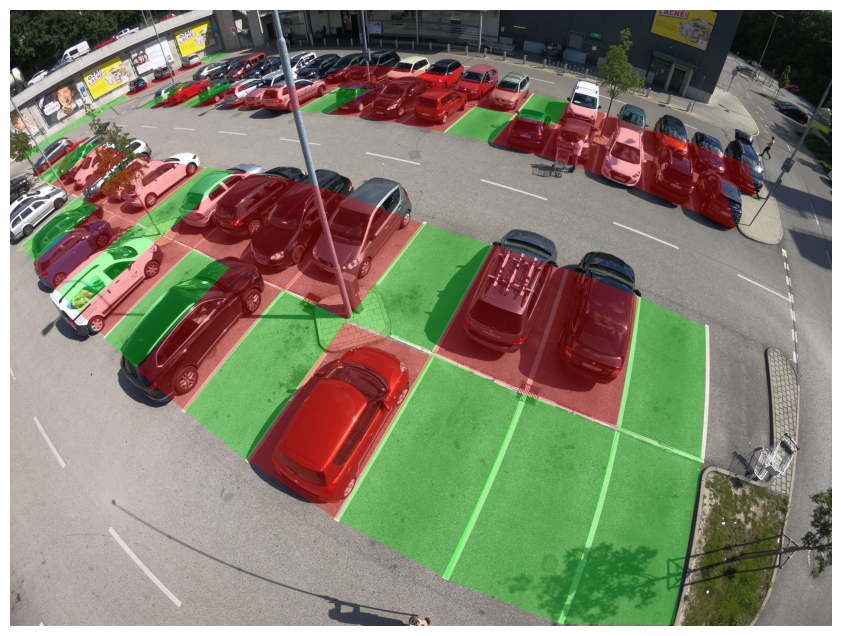

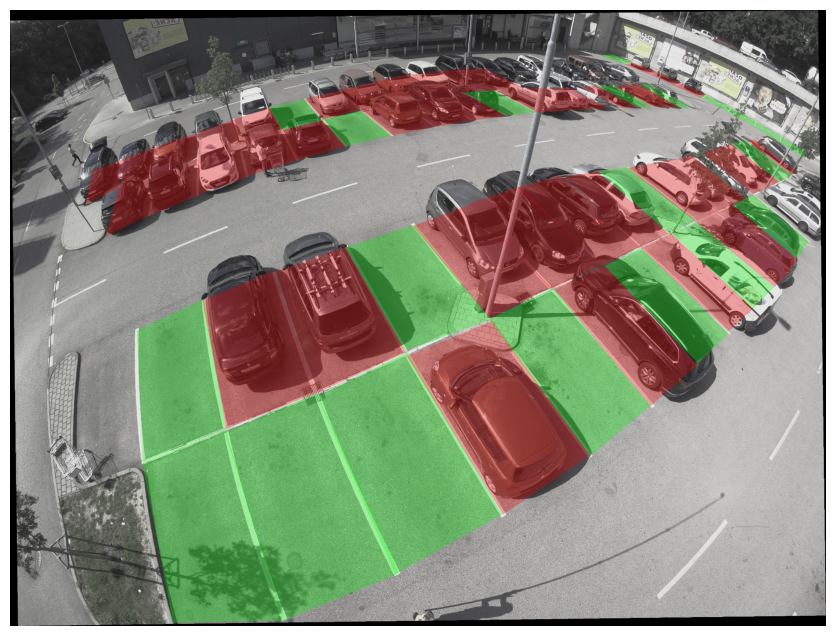

In [ ]:
# Visualize dataset
from dataset import acpds
from utils import transforms
from utils import visualize as vis

train_ds, valid_ds, test_ds = acpds.create_datasets('dataset/data')

image_batch, rois_batch, labels_batch = next(iter(valid_ds))
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image = transforms.preprocess(image_raw, res=1440)
vis.plot_ds_image(image, rois, labels, show=True)

image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image_aug, rois_aug = transforms.augment(image_raw, rois)
image_aug = transforms.preprocess(image_aug, res=1440)
vis.plot_ds_image(image_aug, rois_aug, labels, show=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.2MB/s]


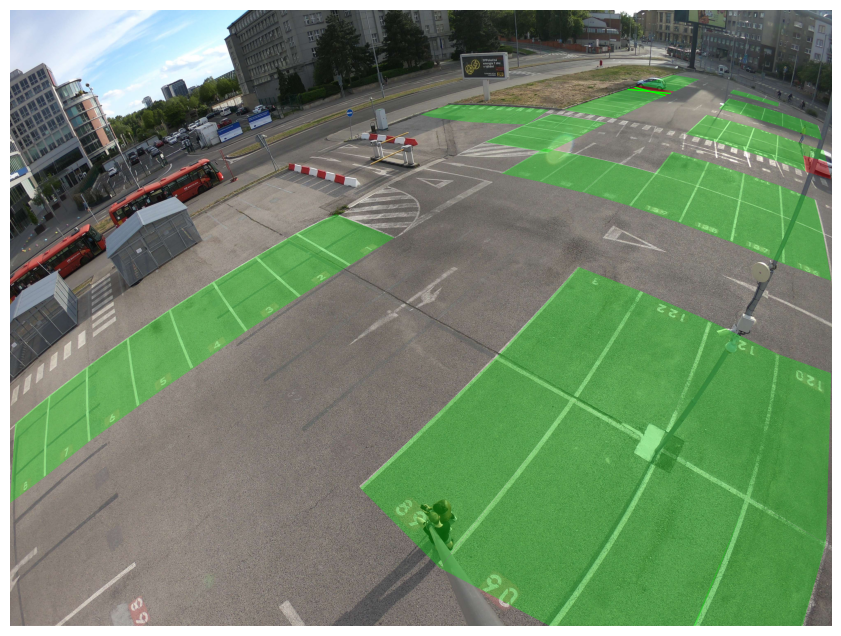

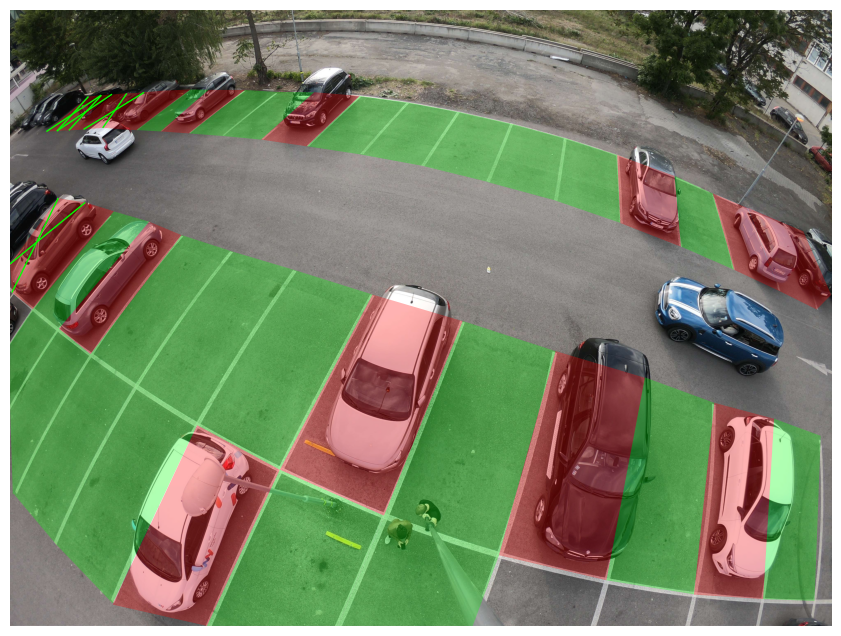

In [ ]:
# Plot model predictions
# create model
from models.rcnn import RCNN
model = RCNN()

# load model weights
weights_path = 'weights.pt'
if not os.path.exists(weights_path):
    r = requests.get('https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2FRCNN_128_square_gopro.pt')
    with open(weights_path, 'wb') as f:
        f.write(r.content)
model.load_state_dict(torch.load(weights_path, map_location='cpu'))

# plot test predictions
for i, (image_batch, rois_batch, labels_batch) in enumerate(test_ds):
    if i == 2: break
    image, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
    image = transforms.preprocess(image)
    with torch.no_grad():
        class_logits = model(image, rois)
        class_scores = class_logits.softmax(1)[:, 1]
    vis.plot_ds_image(image, rois, class_scores, labels)

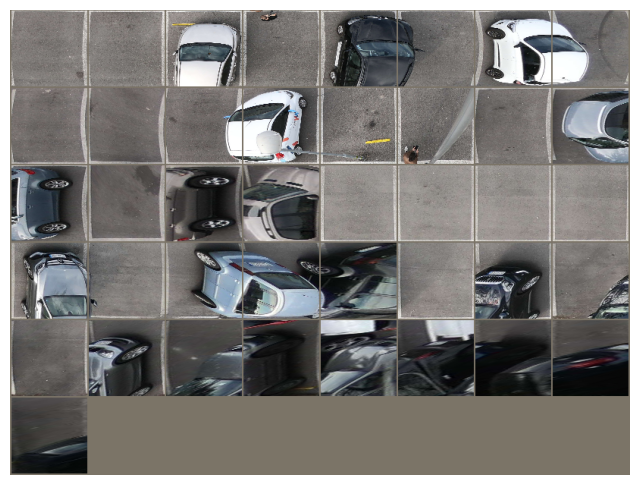

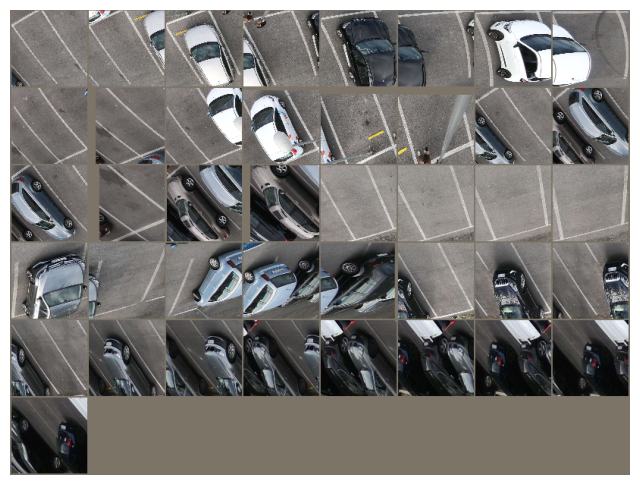

In [ ]:
# Plot ROI warps
from models.utils import pooling

warps = pooling.roi_pool(image, rois, 100, 'qdrl')
vis.show_warps(warps)
warps = pooling.roi_pool(image, rois, 100, 'square')
vis.show_warps(warps)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


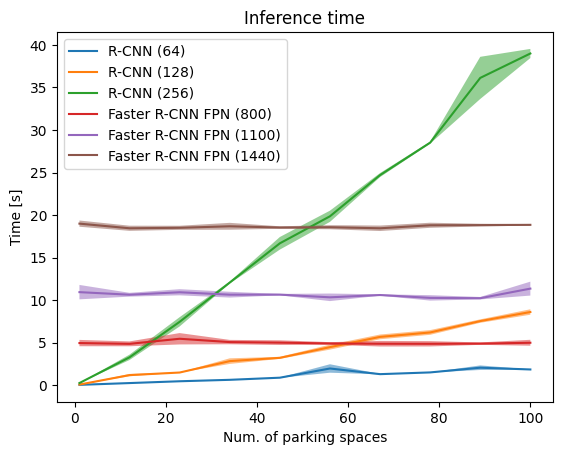

In [ ]:
# Speed comparison
from models.rcnn import RCNN
# from models.rcnn import RCNN
# model = RCNN()
from models.faster_rcnn_fpn import FasterRCNN_FPN

def time_model(model, res=[1920, 1440], n=3):
    image = torch.zeros([3, res[1], res[0]])
    L_arr = torch.linspace(1, 100, steps=10, dtype=torch.int32)
    mean = np.zeros_like(L_arr, dtype=np.float32)
    ese = np.zeros_like(L_arr, dtype=np.float32)
    for i, L in enumerate(L_arr):
        times = np.zeros(n)
        for j in range(n):
            rois = torch.rand([L, 4, 2])
            t0 = time.time()
            out = model(image, rois)
            t1 = time.time()
            times[j] = t1 - t0
        mean[i] = np.mean(times)
        ese[i] = np.std(times) / np.sqrt(len(times))
    return L_arr, mean, ese

times = {}
times['R-CNN (64)']  = time_model(RCNN(roi_res=64),  res=[4000, 3000])
times['R-CNN (128)'] = time_model(RCNN(roi_res=128), res=[4000, 3000])
times['R-CNN (256)'] = time_model(RCNN(roi_res=256), res=[4000, 3000])
times['Faster R-CNN FPN (800)']   = time_model(FasterRCNN_FPN(), res=[1067, 800])
times['Faster R-CNN FPN (1100)']  = time_model(FasterRCNN_FPN(), res=[1467, 1100])
times['Faster R-CNN FPN (1440)']  = time_model(FasterRCNN_FPN(), res=[1920, 1440])

for k, v in times.items():
    plt.plot(v[0], v[1], label=k)
    plt.fill_between(v[0], v[1]-v[2], v[1]+v[2], alpha=0.5)

plt.title('Inference time')
plt.xlabel('Num. of parking spaces')
plt.ylabel('Time [s]')
plt.legend()
plt.show()

In [ ]:
# FPN level resolutions
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
backbone = resnet_fpn_backbone('resnet50', pretrained=False)
image = torch.zeros([3, 1920, 1440])
out = backbone.body(image[None])
for k, v in out.items():
    print(k, v.shape)

0 torch.Size([1, 256, 480, 360])
1 torch.Size([1, 512, 240, 180])
2 torch.Size([1, 1024, 120, 90])
3 torch.Size([1, 2048, 60, 45])
